<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>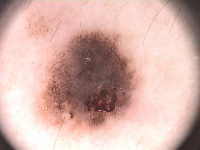</td><td>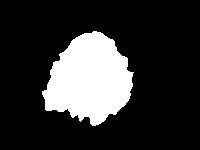</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-08-11 15:43:12--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-08-11 15:43:13--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf89239fcb3f7719cb30d13296d.dl.dropboxusercontent.com/cd/0/inline/Bq0IrlU0IfGJLkEOg2T9ifAj-wm68KcZ6uPaPP8YzEImufiTKxO60MRQ8jTmkZgIFQmJI061kHD9exY61irXmzTx9pXMhe1gqWS8PZNq6cCuwrvqDIwBzBpGOTa9gnVS-p6BJnvEx160V00qQS05dPFLIchShCIl4D9xmL_p5em9Dw/file# [following]
--2022-08-11 15:43:13--  https://ucf89239fcb3f7719cb30d13296d.dl.dropboxusercontent.com/cd/0/inline/Bq0IrlU0IfGJLkEOg2T9ifAj-wm68KcZ6uPaPP8YzEImufiTKxO60MRQ8jTmkZ

In [ ]:
!ls

PH2Dataset		 segnet_focal_history.csv   unet_bce_history.csv
PH2Dataset.rar		 segnet_lovasz_history.csv  unet_dice_history.csv
sample_data		 unet2_bce_history.csv	    unet_focal_history.csv
segnet_bce_history.csv	 unet2_dice_history.csv     unet_lovasz_history.csv
segnet_dice_history.csv  unet2_focal_history.csv


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

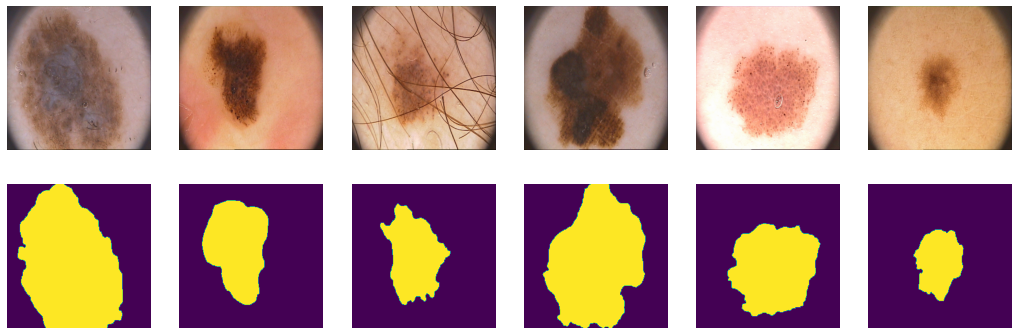

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
print(len(data_tr))

4


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

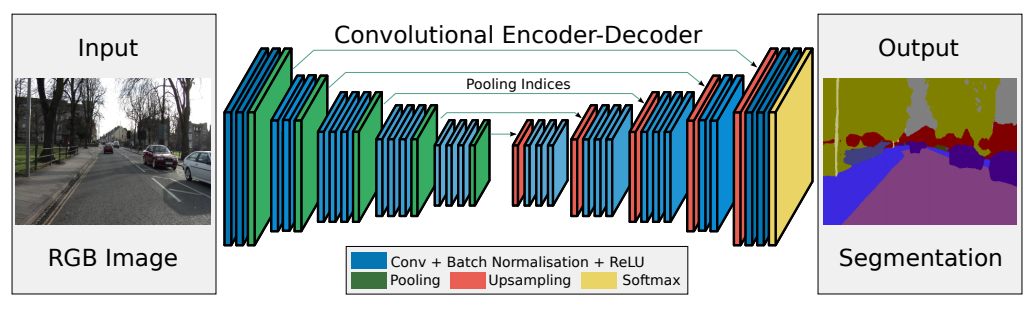

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
!pip install GPUtil
import GPUtil

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.bottleneck_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
            
        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # decoder (upsampling)
        self.unpool0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        self.unpool1 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b1, indb = self.bottleneck_pool(self.bottleneck_conv1(e3))
        b2 = self.bottleneck_conv2(self.bottleneck_unpool(b1, indb))

        # decoder
        d0 = self.dec_conv0(self.unpool0(b2, ind3))
        d1 = self.dec_conv1(self.unpool1(d0, ind2))
        d2 = self.dec_conv2(self.unpool2(d1, ind1))
        d3 = self.dec_conv3(self.unpool3(d2, ind0)) # no activation
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    loss = F.relu(y_pred) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val):
    
    history = {"train_losses": [], "val_losses": [], "train_scores": [], "val_scores": []}

    scheduler = ExponentialLR(opt, gamma=0.9)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        tr_score = 0.0
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            Y_prob = (torch.sigmoid(Y_pred) > 0.5).int()
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
        
            tr_score += metric(Y_prob, Y_batch).mean().item()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        
        scheduler.step()
        tr_score = tr_score / len(data_tr)

        history["train_scores"].append(tr_score)

        history["train_losses"].append(avg_loss.item())

        toc = time()
        print('loss: %f' % avg_loss)

        GPUtil.showUtilization()
        del X_batch, Y_batch, loss, Y_pred, Y_prob
        torch.cuda.empty_cache()
        GPUtil.showUtilization()
        # show intermediate results

        model.eval()  # testing mode
        avg_loss_val = 0
        val_score = 0.0

        with torch.no_grad():
            
            for X_batch, Y_batch in data_val:

              X_batch = X_batch.to(device)
              Y_batch = Y_batch.to(device)

              Y_pred = model(X_batch)
              Y_prob = torch.sigmoid(Y_pred) > 0.5
              Y_mask = Y_prob.int()

              loss = loss_fn(Y_batch, Y_pred)
              avg_loss_val += loss / len(data_val)
              score = metric(Y_mask,Y_batch).mean().item()
              val_score += score / len(data_val)
            
            history["val_scores"].append(val_score)

            history["val_losses"].append(loss.item())
            
        
        # Визуализируем промежуточные результаты
        
        X_val, Y_val = next(iter(data_val))

        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
        Y_pred = model(X_val)
        Y_prob = torch.sigmoid(Y_pred) > 0.5
        Y_hat = Y_prob.int()
        Y_hat = Y_hat.detach().cpu() # detach and put into cpu # detach and put into cpu


        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val.detach().cpu()[k, 0], cmap='gray')
            plt.title('Target')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        
        del X_val, Y_val, X_batch, Y_batch, Y_pred, Y_prob, avg_loss_val, loss, tr_score, val_score, score
        torch.cuda.empty_cache()

    torch.cuda.empty_cache()

    return pd.DataFrame(history)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

Не будем возвращать массив предсказаний модели на новых данных, а лучше отрисуем получившиеся маски на выходе:

In [ ]:
def predict(model, data):
    

    model.eval()  # testing mode
    for X_batch, Y_batch in data:
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)
      Y_pred = model(X_batch)
      Y_prob = (torch.sigmoid(Y_pred)).detach().cpu() > 0.5
      Y_hat = Y_prob.int()
      Y_hat = Y_hat.detach().cpu()

      # Visualize tools
      clear_output(wait=True)
      for k in range(6):
          plt.subplot(3, 6, k+1)
          plt.imshow(np.rollaxis(X_batch[k].cpu().numpy(), 0, 3), cmap='gray')
          plt.title('Real')
          plt.axis('off')

          plt.subplot(3, 6, k+7)
          plt.imshow(Y_hat[k, 0], cmap='gray')
          plt.title('Output')
          plt.axis('off')

          plt.subplot(3, 6, k+13)
          plt.imshow(Y_batch.detach().cpu()[k, 0], cmap='gray')
          plt.title('Target')
          plt.axis('off')
      
      del X_batch, Y_batch, Y_hat, Y_pred, Y_prob
      torch.cuda.empty_cache()

      #return np.array(Y_prob)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          Y_pred = (torch.sigmoid(model(X_batch.to(device))) > 0.5).int()
          scores += metric(Y_pred, Y_label.to(device)).mean().item()
          GPUtil.showUtilization()
          del X_batch, Y_pred, Y_label
          torch.cuda.empty_cache()
          GPUtil.showUtilization()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


Будем сохранять датафрэймы с историей обучения в csv файле, ибо в какой-то момент можно получить переполнение памяти для cuda. 

In [ ]:
model = SegNet().to(device)

In [ ]:
torch.cuda.empty_cache()

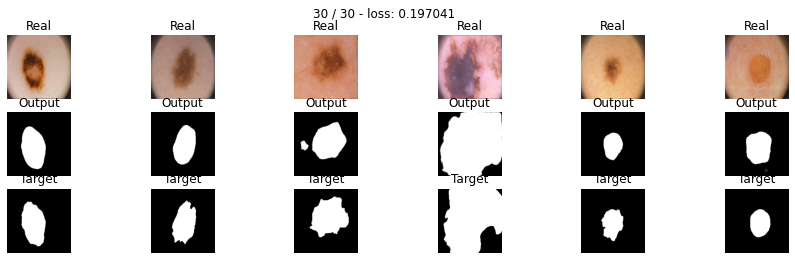

In [ ]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr= 1e-4)
bce_history = train(model, optim, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)
bce_history.to_csv('segnet_bce_history.csv')

In [ ]:
segnet_bce_history = bce_history

In [ ]:
bce_val_score = score_model(model, iou_pytorch, data_val)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 53% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 38% |
| ID | GPU | MEM |
------------------
|  0 | 79% | 53% |
| ID | GPU | MEM |
------------------
|  0 | 79% | 38% |


In [ ]:
bce_val_score

0.8238397538661957

Напишем функцию для визуализации истории по мере обучения нейросети:

In [ ]:
from IPython.core.pylabtools import figsize
def plot_history (history: pd.DataFrame, model: str, loss: str):
  fig, ax = plt.subplots(1, 2, figsize = (12, 8))
  history.plot(y = ['train_losses', 'val_losses'], ax = ax[0], xlabel = 'epoch', ylabel = 'loss')
  history.plot(y = ['train_scores', 'val_scores'], ax = ax[1], xlabel = 'epoch', ylabel = 'score')
  fig.suptitle(f'Model: {model}, Loss: {loss}')

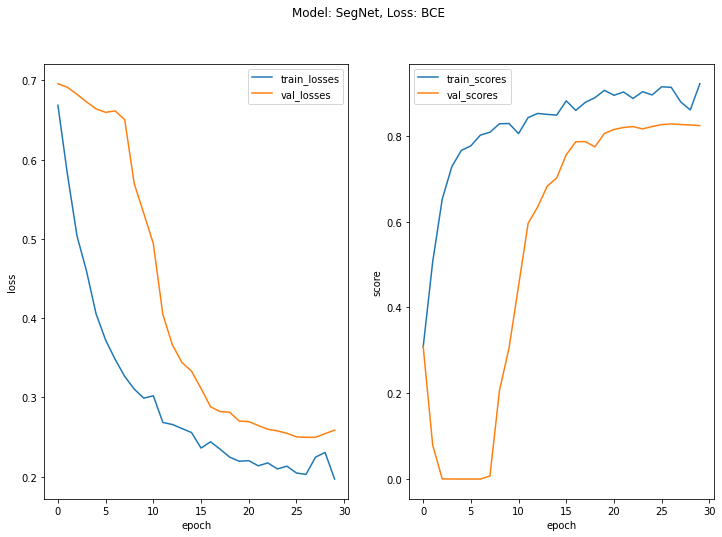

In [ ]:
plot_history(bce_history, "SegNet", "BCE")

Проверим среднее качество предсказаний модели на тестовом наборе данных:

In [ ]:
bce_test_score = score_model(model, iou_pytorch, data_ts)

| ID | GPU | MEM |
------------------
|  0 | 73% | 53% |
| ID | GPU | MEM |
------------------
|  0 | 73% | 38% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 53% |
| ID | GPU | MEM |
------------------
|  0 | 58% | 38% |


In [ ]:
bce_test_score

0.8272272646427155

In [ ]:
torch.cuda.empty_cache()

Посмотрим на результаты предсказаний на тестовом наборе данных:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

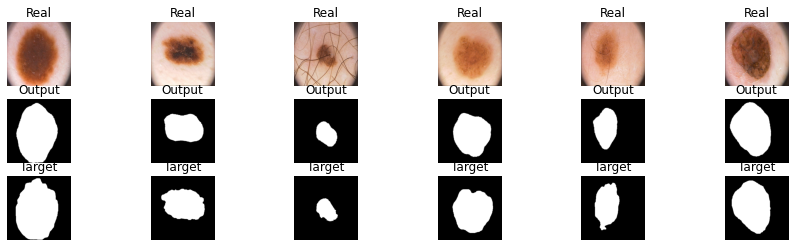

In [ ]:
predict(model, data_ts)

В целом, если судить по графикам изменения функции потерь, можно утверждать, что признаки переобучения появляются примерно к 30 эпохе, однако они не так существенны, как могли бы быть, величина коэффициента обучения также сыграла свою роль.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    smooth = 1e-3
    y_pred = torch.sigmoid(y_pred)
    num = 2 * torch.sum (y_real*y_pred, (1, 2, 3))
    den = torch.sum (y_real, (1, 2, 3)) + torch.sum (y_pred, (1, 2, 3))
    res = 1 - torch.mean((num + smooth) / (den + smooth))
    return res 

Проводим тестирование:

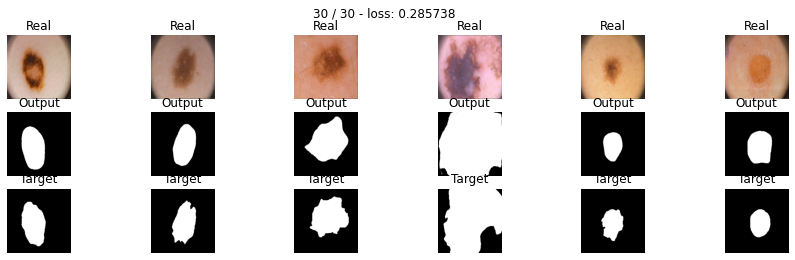

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
segnet_dice_history = train(model_dice, optimaizer, dice_loss, iou_pytorch, max_epochs, data_tr, data_val)
segnet_dice_history.to_csv('segnet_dice_history.csv')

In [ ]:
dice_val_score = score_model(model_dice, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 80% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 80% | 46% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 61% | 46% |


In [ ]:
dice_val_score

0.8369950950145721

In [ ]:
dice_test_score = score_model(model_dice, iou_pytorch, data_ts)

| ID | GPU | MEM |
------------------
|  0 | 88% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 88% | 46% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 57% | 46% |


In [ ]:
dice_test_score

0.8287269771099091

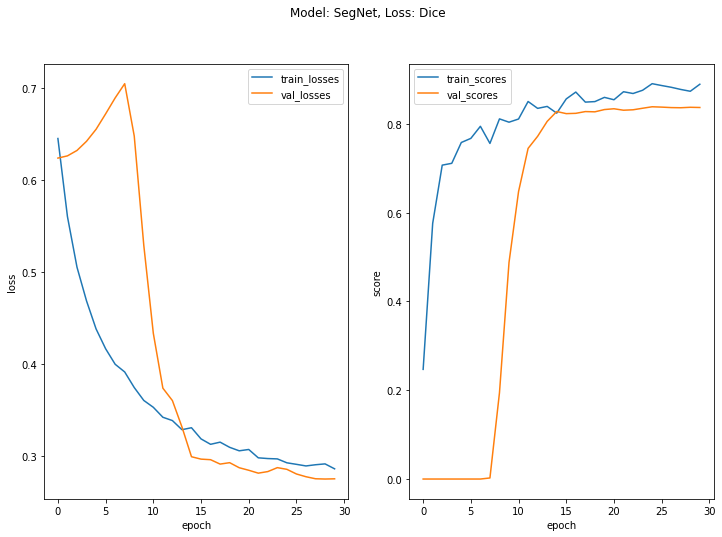

In [ ]:
plot_history(segnet_dice_history, "SegNet", "Dice")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

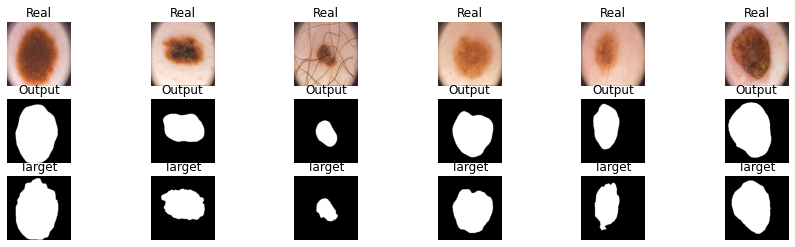

In [ ]:
predict(model_dice, data_ts)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


В данном случае можно выразить focal_loss через стабильную bce, написанную ранее:

In [ ]:
def focal_loss(y_real, y_pred, gamma = 2):
    bce = F.relu(y_pred) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    loss = (1-torch.exp(-bce))**gamma*bce
    your_loss = loss.mean() # hint: torch.clamp
    return your_loss

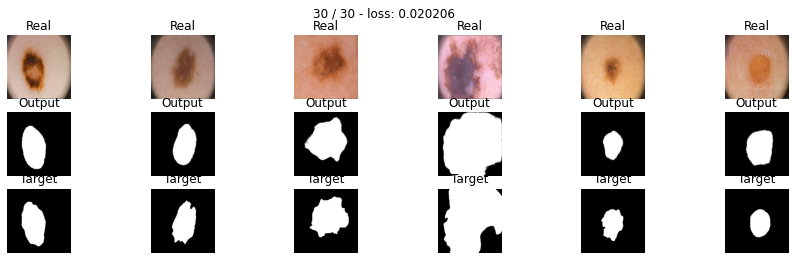

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
segnet_focal_history = train(model_focal, optimaizer, focal_loss, iou_pytorch, max_epochs, data_tr, data_val)
segnet_focal_history.to_csv('segnet_focal_history.csv')

In [ ]:
focal_val_score = score_model(model_focal, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 70% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 70% | 46% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 56% | 46% |


In [ ]:
focal_val_score

0.826583743095398

In [ ]:
focal_test_score = score_model(model_focal, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 60% | 46% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 46% |


In [ ]:
focal_test_score

0.8233788311481476

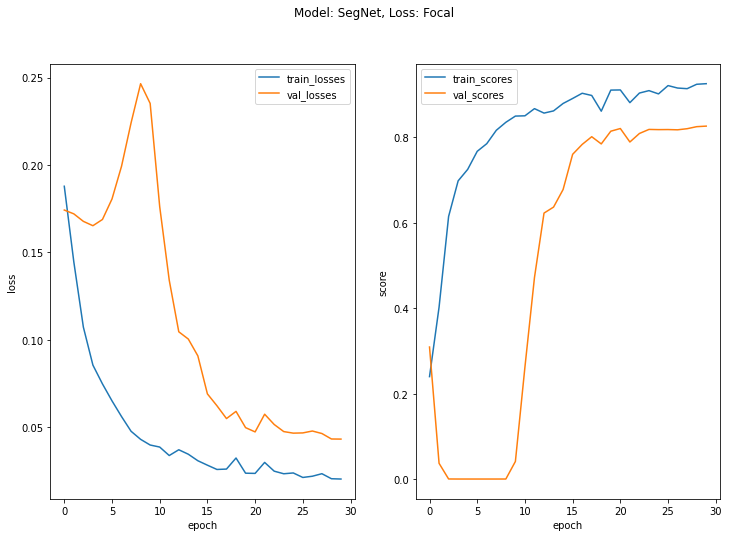

In [ ]:
plot_history(segnet_focal_history, "SegNet", "Focal")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

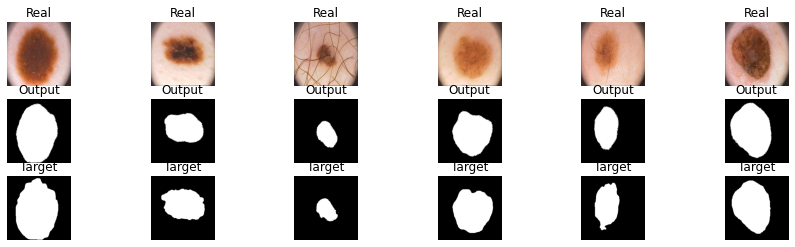

In [ ]:
predict(model_focal, data_ts)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Решил реализовать Lovasz loss. Руководствовался следующей статьёй - https://habr.com/ru/company/ods/blog/488852/?ysclid=l6eys32uft440780715.

Lovasz loss - принцип его действия основан на расширении Ловаса, которая позволяет построить выпуклую (удовлетворяющую неравенству Йенсена) и суррогатную (хорошо моделирующую заданную) функцию, для которой уже возможна оптимизация градиентными методами. Сам алгоритм основан на анализе отсортированных ошибок.

In [ ]:
def lovasz_grad(gt_sorted): # функция для вычисления градиента

    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0) # cumsum возвращает накапливаемую сумму
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(y_real, y_pred):

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    
    if len(y_real) == 0:
        return y_pred.sum() * 0.
    signs = 2. * y_real.float() - 1. # приводим маски к диапазону {-1,1}
    errors = (1. - y_pred * Variable(signs)) # считаем ошибки
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True) # сортируем ошибки по убыванию
    perm = perm.data
    gt_sorted = y_real[perm] # сортируем маски
    grad = lovasz_grad(gt_sorted) 
    loss = torch.dot(F.relu(errors_sorted), Variable(grad)) 
    return loss

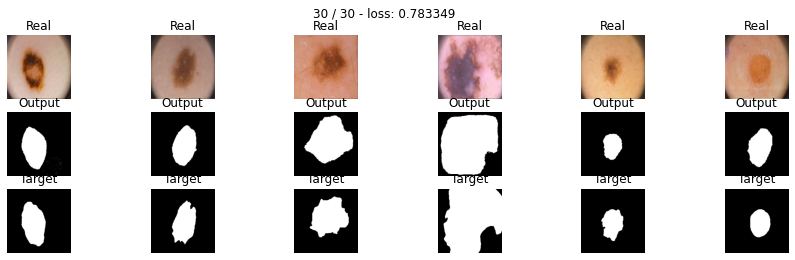

In [ ]:
model_lovasz = SegNet().to(device)
max_epochs = 30
optimaizer = torch.optim.Adam(model_lovasz.parameters(), lr=3e-4)
segnet_lovasz_history = train(model_lovasz, optimaizer, lovasz_hinge, iou_pytorch, max_epochs, data_tr, data_val)
segnet_lovasz_history.to_csv('segnet_lovasz_history.csv')

In [ ]:
lovasz_val_score = score_model(model_lovasz, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 80% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 80% | 46% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 60% | 46% |


In [ ]:
lovasz_val_score

0.7468820512294769

In [ ]:
lovasz_test_score = score_model(model_lovasz, iou_pytorch, data_ts)

| ID | GPU | MEM |
------------------
|  0 | 92% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 92% | 46% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 61% |
| ID | GPU | MEM |
------------------
|  0 | 55% | 46% |


In [ ]:
lovasz_test_score

0.7353889048099518

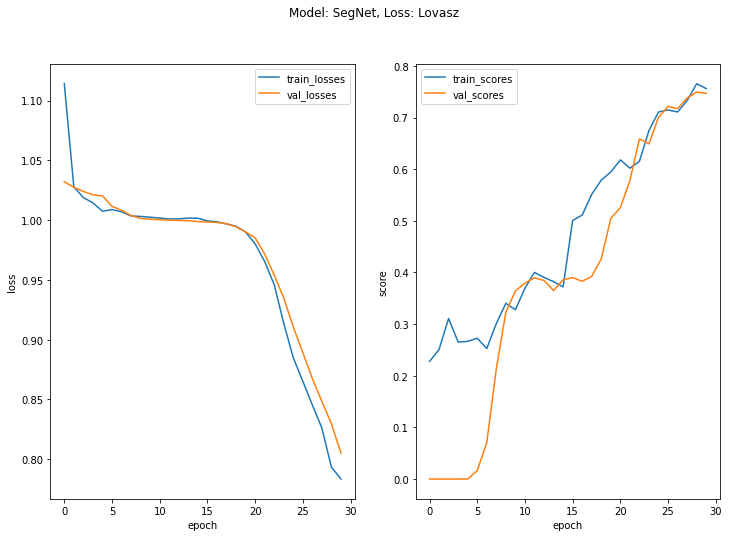

In [ ]:
plot_history(segnet_lovasz_history, "SegNet", "Lovasz")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

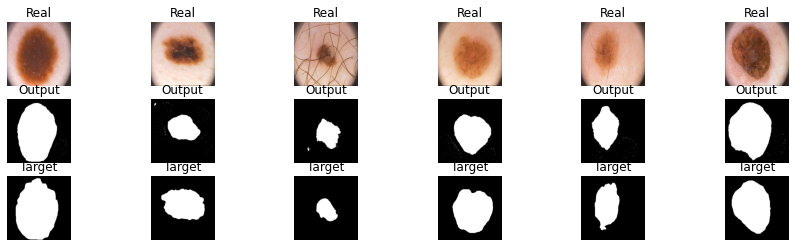

In [ ]:
predict(model_lovasz, data_ts)

Теперь создадим 2 словаря для доступа к данным средних значений метрики для всех реализованных функций потерь в ноутбуке относительно валидационного датасета и тестовых данных (модель SegNet):

In [ ]:
segnet_val_scores = {"bce": bce_val_score, "dice": dice_val_score, "focal": focal_val_score, "lovasz": lovasz_val_score}


segnet_test_scores = {"bce": bce_test_score, "dice": dice_test_score, "focal": focal_test_score, "lovasz": lovasz_test_score}

In [ ]:
segnet_test_scores

{'bce': 0.8272272646427155,
 'dice': 0.8287269771099091,
 'focal': 0.8233788311481476,
 'lovasz': 0.7353889048099518}

In [ ]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

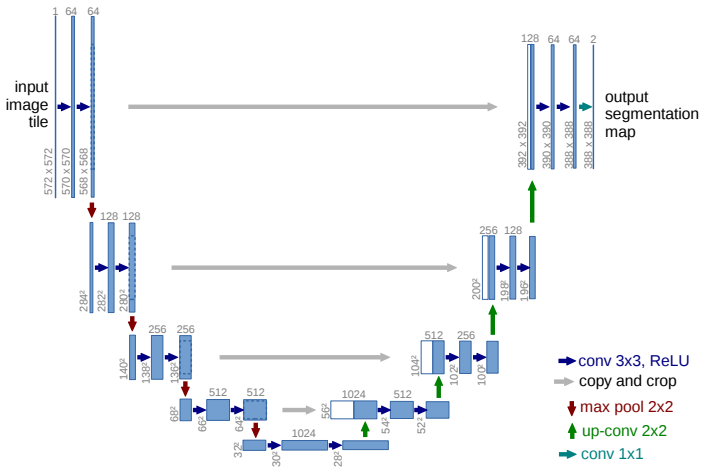

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=False)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=False)# 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= 128, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=False) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),        
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),           
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=False) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),           
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),            
            nn.BatchNorm2d(512),
            nn.ReLU()
        )     

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),            
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU()
        )    
           
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),           
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # bottleneck
        b = self.bottleneck_conv(e7)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim =1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim =1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim =1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim =1)) # no activation function
        
        return d3

In [ ]:
unet_bce_model = UNet().to(device)

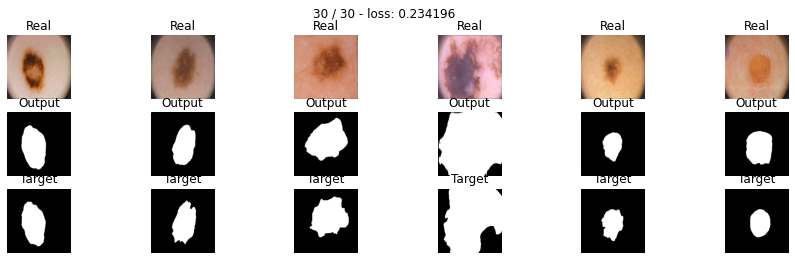

In [ ]:
unet_bce_history = train(unet_bce_model, torch.optim.Adam(unet_bce_model.parameters(), lr=1e-4), bce_loss, iou_pytorch, 30, data_tr, data_val)
unet_bce_history.to_csv('unet_bce_history.csv')

In [ ]:
bce_val_score = score_model(unet_bce_model, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 91% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 91% | 57% |
| ID | GPU | MEM |
------------------
|  0 | 75% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 75% | 57% |


In [ ]:
bce_val_score

0.8446248471736908

In [ ]:
bce_test_score = score_model(unet_bce_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 57% | 57% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 57% |


In [ ]:
bce_test_score

0.8401771187782288

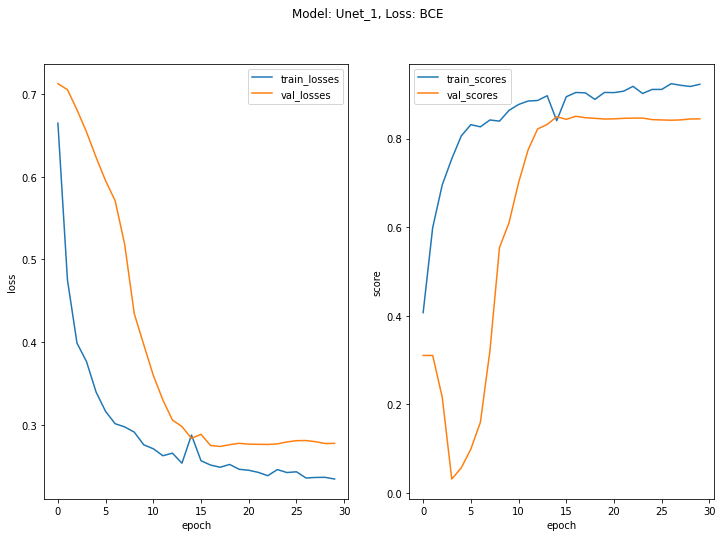

In [ ]:
plot_history(unet_bce_history, "Unet_1", "BCE" )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

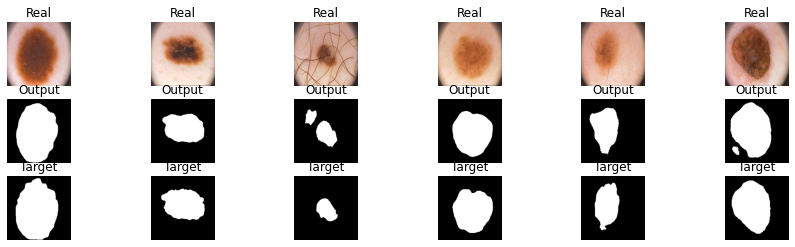

In [ ]:
predict(unet_bce_model, data_ts)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
unet_dice_model = UNet().to(device)

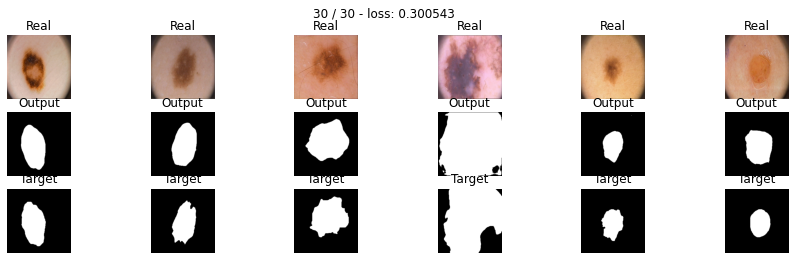

In [ ]:
unet_dice_history = train(unet_dice_model, torch.optim.Adam(unet_dice_model.parameters(), lr=1e-4), dice_loss, iou_pytorch, 30, data_tr, data_val)
unet_dice_history.to_csv('unet_dice_history.csv')

In [ ]:
dice_val_score = score_model(unet_dice_model, iou_pytorch, data_val)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 59% | 57% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 57% |


In [ ]:
dice_val_score

0.8452585339546204

In [ ]:
dice_test_score = score_model(unet_dice_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 60% | 57% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 57% |


In [ ]:
dice_test_score

0.8421163260936737

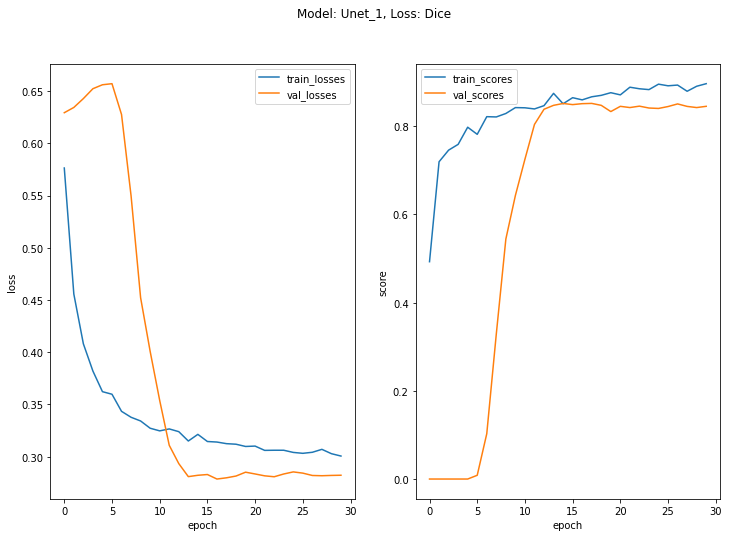

In [ ]:
plot_history(unet_dice_history, "Unet_1", "Dice")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

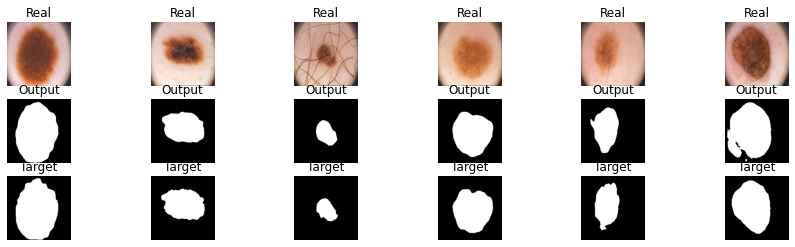

In [ ]:
predict(unet_dice_model, data_ts)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
unet_focal_model = UNet().to(device)

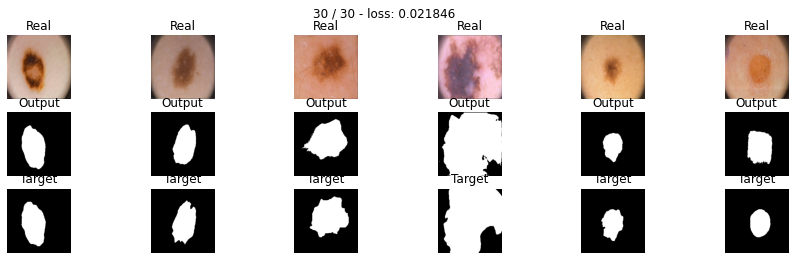

In [ ]:
unet_focal_history = train(unet_focal_model, torch.optim.Adam(unet_focal_model.parameters(), lr=1e-4), focal_loss, iou_pytorch, 30, data_tr, data_val)
unet_focal_history.to_csv('unet_focal_history.csv')

In [ ]:
focal_val_score = score_model(unet_focal_model, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 87% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 87% | 57% |
| ID | GPU | MEM |
------------------
|  0 | 70% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 70% | 57% |


In [ ]:
focal_val_score

0.8502940237522125

In [ ]:
focal_test_score = score_model(unet_focal_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU | MEM |
------------------
|  0 | 59% | 57% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 96% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 57% |


In [ ]:
focal_test_score

0.8463263809680939

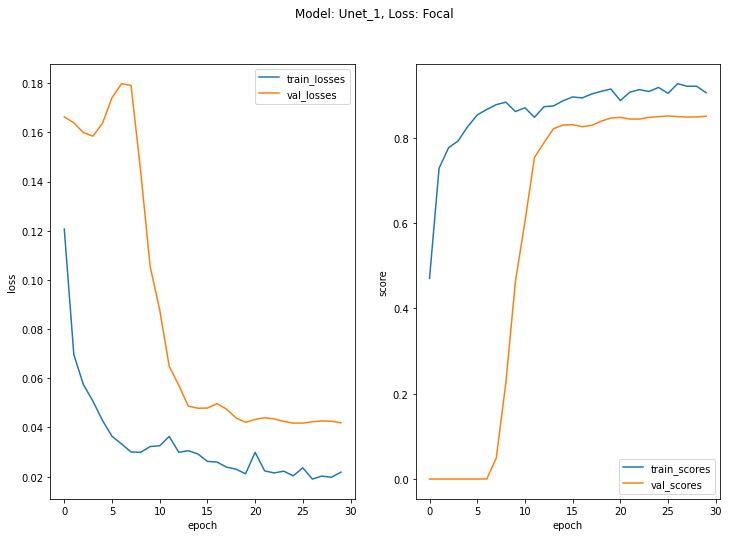

In [ ]:
plot_history(unet_focal_history, "Unet_1", "Focal")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

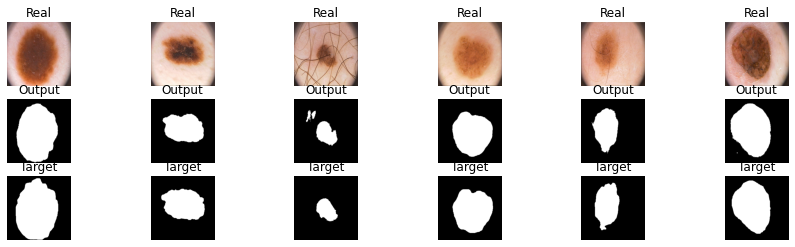

In [ ]:
predict(unet_focal_model, data_ts)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
unet_lovasz_model = UNet().to(device)

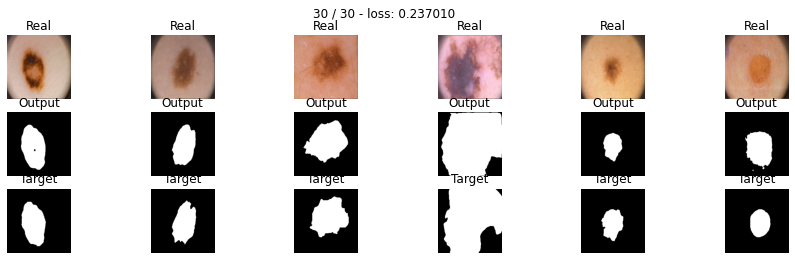

In [ ]:
unet_lovasz_history = train(unet_lovasz_model, torch.optim.Adam(unet_lovasz_model.parameters(), lr=3e-4), lovasz_hinge, iou_pytorch, 30, data_tr, data_val)
unet_lovasz_history.to_csv('unet_lovasz_history.csv')

In [ ]:
lovasz_val_score = score_model(unet_lovasz_model, iou_pytorch, data_val)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 80% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 80% |
| ID | GPU | MEM |
------------------
|  0 | 89% | 80% |
| ID | GPU | MEM |
------------------
|  0 | 89% | 80% |


In [ ]:
lovasz_val_score

0.8474801182746887

In [ ]:
lovasz_test_score = score_model(unet_lovasz_model, iou_pytorch, data_ts)

| ID | GPU | MEM |
------------------
|  0 | 72% | 80% |
| ID | GPU | MEM |
------------------
|  0 | 72% | 80% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 80% |
| ID | GPU | MEM |
------------------
|  0 | 45% | 80% |


In [ ]:
lovasz_test_score

0.850105345249176

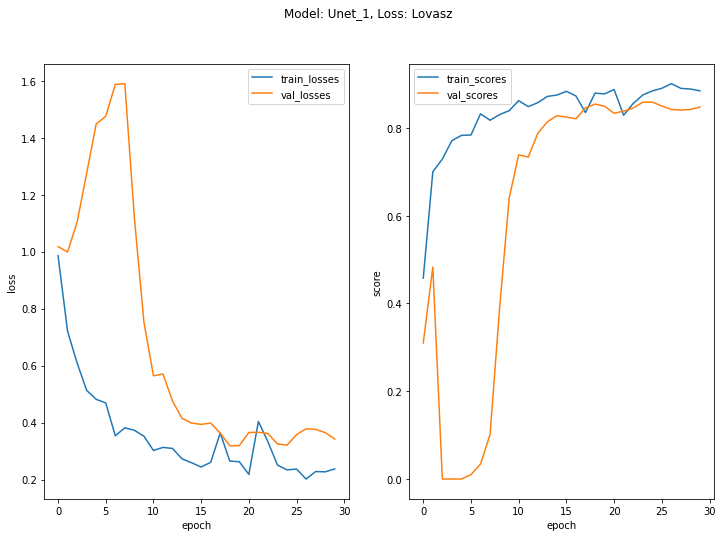

In [ ]:
plot_history(unet_lovasz_history, "Unet_1", "Lovasz")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

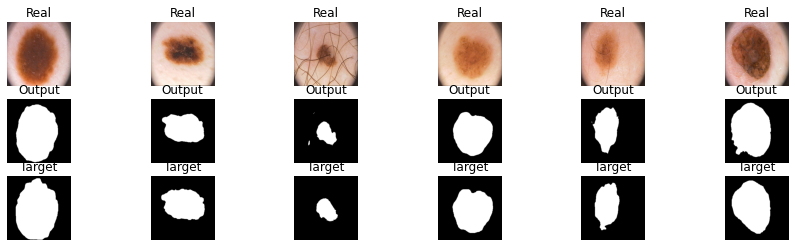

In [ ]:
predict(unet_lovasz_model, data_ts)

Аналогичные действия со словарями для хранения значений метрики проделаем и для Unet_1:

In [ ]:
unet1_val_scores = {"bce": bce_val_score, "dice": dice_val_score, "focal": focal_val_score, "lovasz": lovasz_val_score}



unet1_test_scores = {"bce": bce_test_score, "dice": dice_test_score, "focal": focal_test_score, "lovasz": lovasz_test_score}

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.pool0 =  nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride = 2),
        nn.BatchNorm2d(64),
        nn.ReLU()
        )
    
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        
        self.pool1 =  nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride = 2),
        nn.BatchNorm2d(128),
        nn.ReLU()
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= 128, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        
        self.pool2 =  nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride = 2),
        nn.BatchNorm2d(256),
        nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),        
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),           
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        
        self.pool3 =  nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride = 2),
        nn.BatchNorm2d(512),
        nn.ReLU()
        )    

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),           
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),            
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
       
            
        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride = 2),
        nn.BatchNorm2d(512),
        nn.ReLU()
        )
        
        
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),            
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU()
        )       
        
        
        self.upsample1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride = 2),
        nn.BatchNorm2d(256),
        nn.ReLU()
        )

        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),           
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
 
        self.upsample2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride = 2),
        nn.BatchNorm2d(128),
        nn.ReLU()
        )
        
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),           
            nn.BatchNorm2d(64),
            nn.ReLU()
        )


        self.upsample3 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride = 2),
        nn.BatchNorm2d(64),
        nn.ReLU()
        )
        
        self.dec_conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )
        

    def forward(self, x):
          # encoder
          e0 = self.enc_conv0(x)
          e1 = self.pool0(e0)
          e2 = self.enc_conv1(e1)
          e3 = self.pool1(e2)
          e4 = self.enc_conv2(e3)
          e5 = self.pool2(e4)
          e6 = self.enc_conv3(e5)
          e7 = self.pool3(e6)

          # bottleneck
          b = self.bottleneck(e7)

          # decoder
          d0 = self.upsample0(b)
          d0 = self.dec_conv0(torch.cat((d0,e6), dim =1))
          d1 = self.upsample1(d0)
          d1 = self.dec_conv1(torch.cat((d1,e4), dim =1))        
          d2 = self.upsample2(d1)
          d2 = self.dec_conv2(torch.cat((d2,e2), dim =1))           
          d3 = self.upsample3(d2)
          d3 = self.dec_conv3(torch.cat((d3,e0), dim =1)) # no activation, return logits
          
          return d3

In [ ]:
unet2_bce_model = UNet2().to(device)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 22           |        cudaMalloc retries: 157       |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   12942 MB |   13281 MB |  109501 GB |  109488 GB |\n|       from large pool |   12869 MB |   13229 MB |  109490 GB |  109477 GB |\n|       from small pool |      73 MB |      75 MB |      11 GB |      11 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |   12942 MB |   13281 MB |  109501 GB |  109488 GB |\n|       from large pool |   12869 MB |   13229 MB |

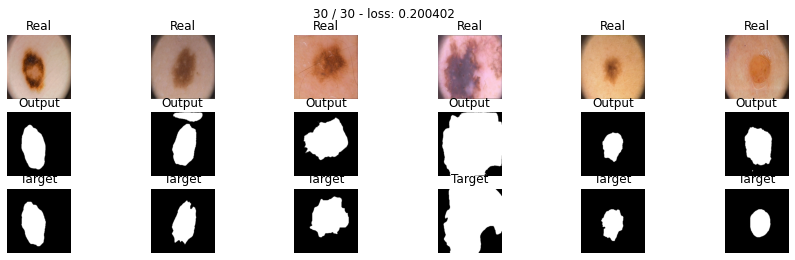

In [ ]:
unet2_bce_history = train(unet2_bce_model, torch.optim.Adam(unet2_bce_model.parameters(), lr=1e-4), bce_loss, iou_pytorch, 30, data_tr, data_val)
unet2_bce_history.to_csv('unet2_bce_history.csv')

In [ ]:
unet2_bce_score_val = score_model(unet2_bce_model, iou_pytorch, data_val)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 83% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 83% |
| ID | GPU | MEM |
------------------
|  0 | 90% | 83% |
| ID | GPU | MEM |
------------------
|  0 | 90% | 83% |


In [ ]:
unet2_bce_score_val

0.8553267121315002

In [ ]:
unet2_bce_score_test = score_model(unet2_bce_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 83% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 83% |
| ID | GPU | MEM |
------------------
|  0 | 91% | 83% |
| ID | GPU | MEM |
------------------
|  0 | 91% | 83% |


In [ ]:
unet2_bce_score_test

0.8508186042308807

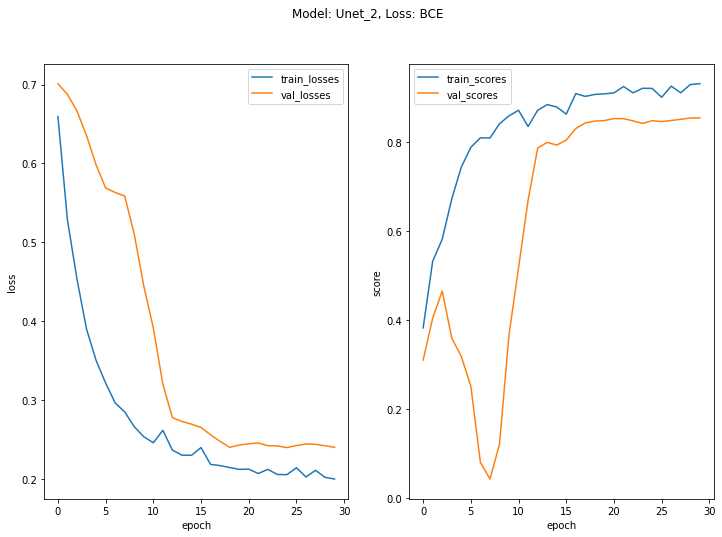

In [ ]:
plot_history(unet2_bce_history, "Unet_2", "BCE")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

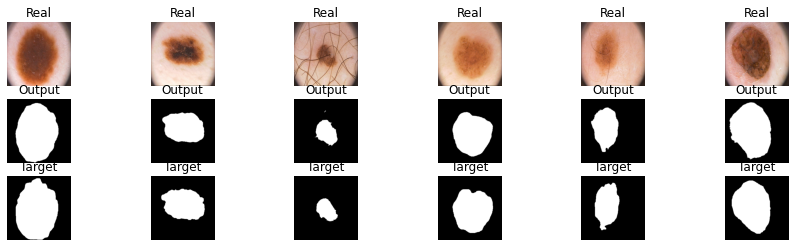

In [ ]:
predict(unet2_bce_model, data_ts)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Aug 11 15:31:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   8166MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
unet2_dice_model = UNet2().to(device)

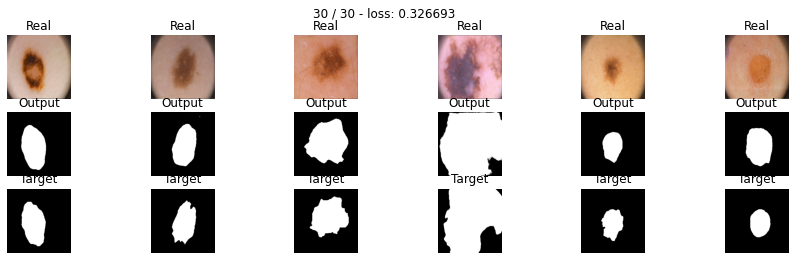

In [ ]:
unet2_dice_history = train(unet2_dice_model, torch.optim.Adam(unet2_dice_model.parameters(), lr=1e-4), dice_loss, iou_pytorch, 30, data_tr, data_val)
unet2_dice_history.to_csv('unet2_dice_history.csv')

In [ ]:
unet2_dice_score_val = score_model(unet2_dice_model, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 72% | 86% |
| ID | GPU | MEM |
------------------
|  0 | 72% | 86% |
| ID | GPU | MEM |
------------------
|  0 | 65% | 86% |
| ID | GPU | MEM |
------------------
|  0 | 65% | 86% |


In [ ]:
unet2_dice_score_val

0.8359119892120361

In [ ]:
unet2_dice_score_test = score_model(unet2_dice_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 86% |
| ID | GPU | MEM |
------------------
|  0 | 31% | 86% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 86% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 86% |


In [ ]:
unet2_dice_score_test

0.832303911447525

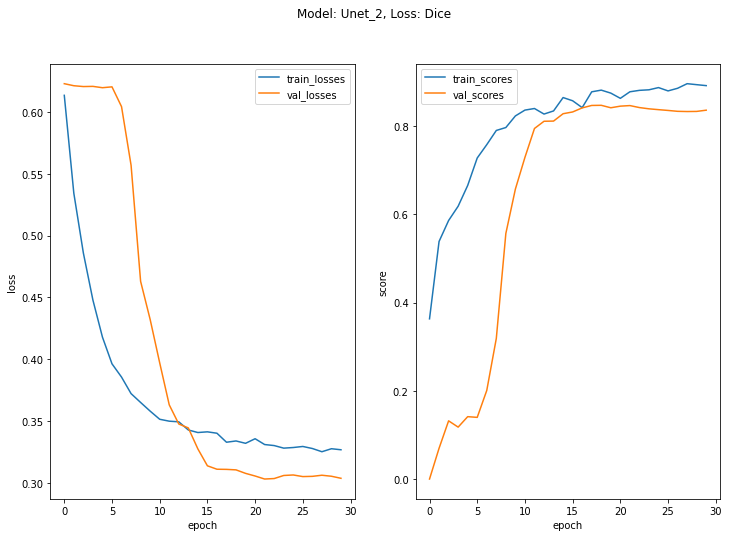

In [ ]:
plot_history(unet2_dice_history, "Unet_2", "Dice")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

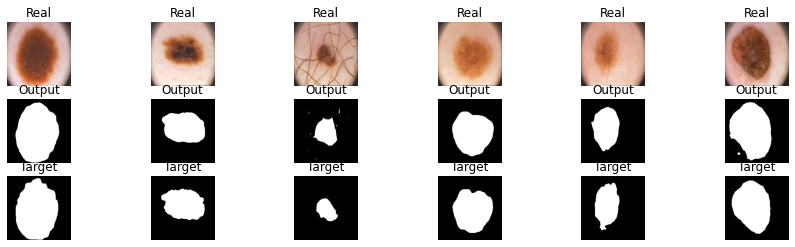

In [ ]:
predict(unet2_dice_model, data_ts)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
unet2_focal_model = UNet2().to(device)

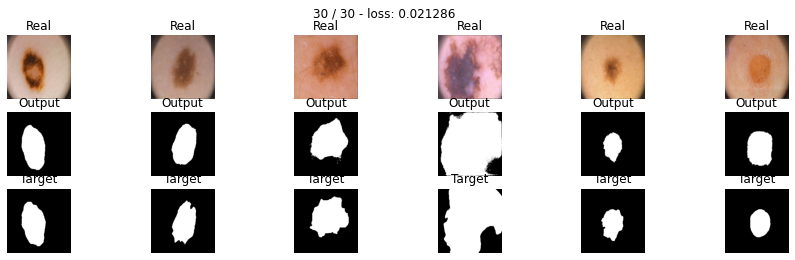

In [ ]:
unet2_focal_history = train(unet2_focal_model, torch.optim.Adam(unet2_focal_model.parameters(), lr=1e-4), focal_loss, iou_pytorch, 30, data_tr, data_val)
unet2_focal_history.to_csv('unet2_focal_history.csv')

In [ ]:
unet2_focal_score_val = score_model(unet2_focal_model, iou_pytorch, data_val)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU | MEM |
------------------
|  0 | 44% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU | MEM |
------------------
|  0 | 36% | 89% |


In [ ]:
unet2_focal_score_val

0.8369656503200531

In [ ]:
unet2_focal_score_test = score_model(unet2_focal_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU | MEM |
------------------
|  0 | 18% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |


In [ ]:
unet2_focal_score_test

0.8375102877616882

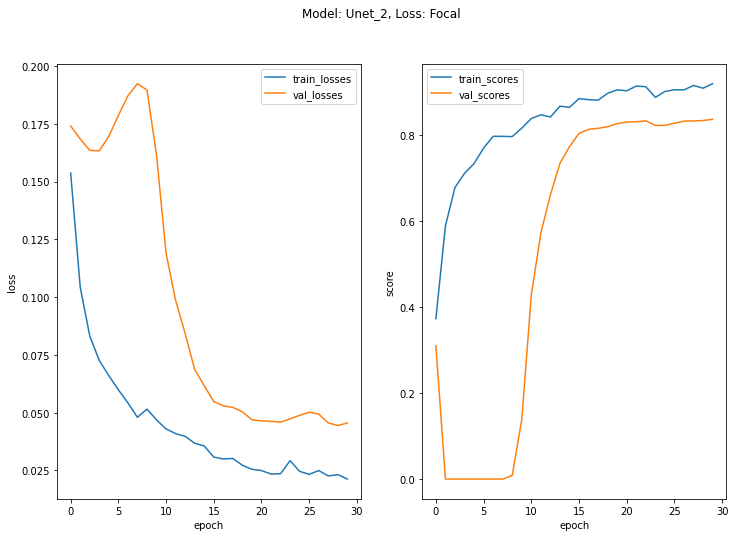

In [ ]:
plot_history(unet2_focal_history, "Unet_2", "Focal")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

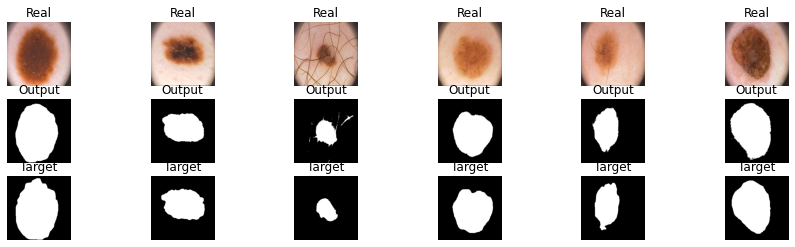

In [ ]:
predict(unet2_focal_model, data_ts)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
unet2_lovasz_model = UNet2().to(device)

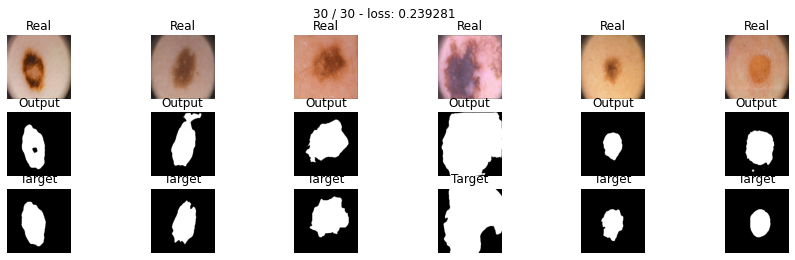

In [ ]:
unet2_lovasz_history = train(unet2_lovasz_model, torch.optim.Adam(unet2_lovasz_model.parameters(), lr=3e-4), lovasz_hinge, iou_pytorch, 30, data_tr, data_val)
unet2_lovasz_history.to_csv('unet2_lovasz_history.csv')

In [ ]:
unet2_lovasz_score_val = score_model(unet2_lovasz_model, iou_pytorch, data_val)

| ID | GPU | MEM |
------------------
|  0 | 65% | 89% |
| ID | GPU | MEM |
------------------
|  0 | 65% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU | MEM |
------------------
|  0 | 54% | 89% |


In [ ]:
unet2_lovasz_score_val

0.8155865967273712

In [ ]:
unet2_lovasz_score_test = score_model(unet2_lovasz_model, iou_pytorch, data_ts)

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |
| ID | GPU  | MEM |
-------------------
|  0 | 100% | 89% |


In [ ]:
unet2_lovasz_score_test

0.821723222732544

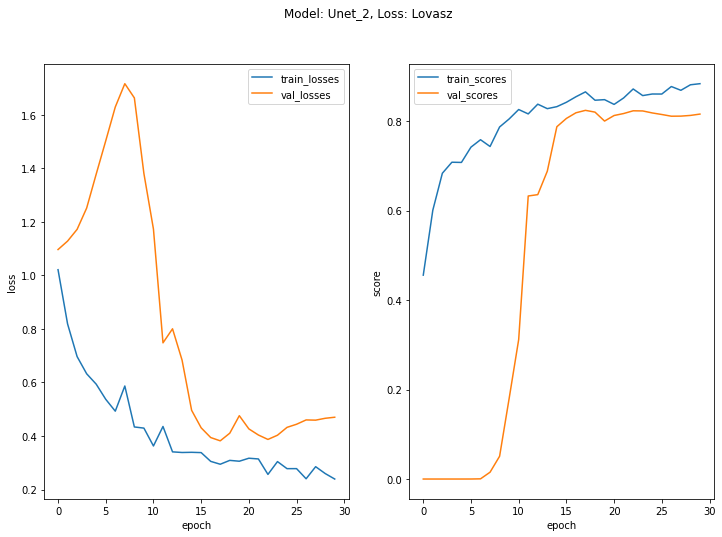

In [ ]:
plot_history(unet2_lovasz_history, "Unet_2", "Lovasz")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier ins

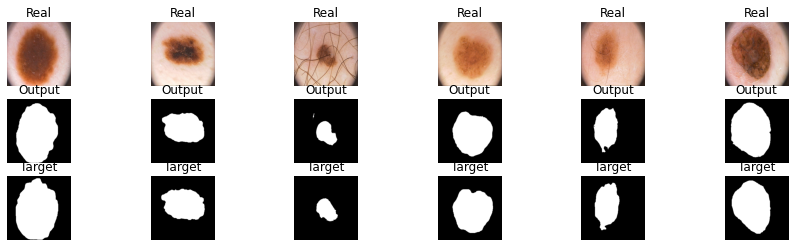

In [ ]:
predict(unet2_lovasz_model, data_ts)

In [ ]:
unet2_val_scores = {"bce": unet2_bce_score_val, "dice": unet2_dice_score_val, "focal": unet2_focal_score_val, "lovasz": unet2_lovasz_score_val}


unet2_test_scores = {"bce": unet2_bce_score_test, "dice": unet2_dice_score_test, "focal": unet2_focal_score_test, "lovasz": unet2_lovasz_score_test}

In [ ]:
segnet_histories = [segnet_bce_history, segnet_dice_history, segnet_focal_history, segnet_lovasz_history]
unet1_histories = [unet_bce_history, unet_dice_history, unet_focal_history, unet_lovasz_history]
unet2_histories = [unet2_bce_history, unet2_dice_history, unet2_focal_history, unet2_lovasz_history]

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Итак, в нашем ноутбуке, который посвящён решению задачи семантической сегментации, реализовано 3 модели: SegNet, Unet1 и Unet2. Различных функций потерь написано 4, то есть всего у нас 12 различных комбинаций. Было бы интересно ответить на следующие вопросы:

1) Какая из функций потерь наиболее применима для решения задачи семантической сегментации родинок или меланом (в рамках каждой модели и относительно всех)?

2) Какая из моделей проявила себя лучше остальных и почему же так случилось?

3) Наконец, какая комбинация (из 15 имеющихся) дала лучший результат для решения задачи?

Вопросы сформулированы - можно приступать к формулировке тезисов и их доказательству.

Построим 3 графика, которые отражают динамику всех функций потерь для каждой модели:

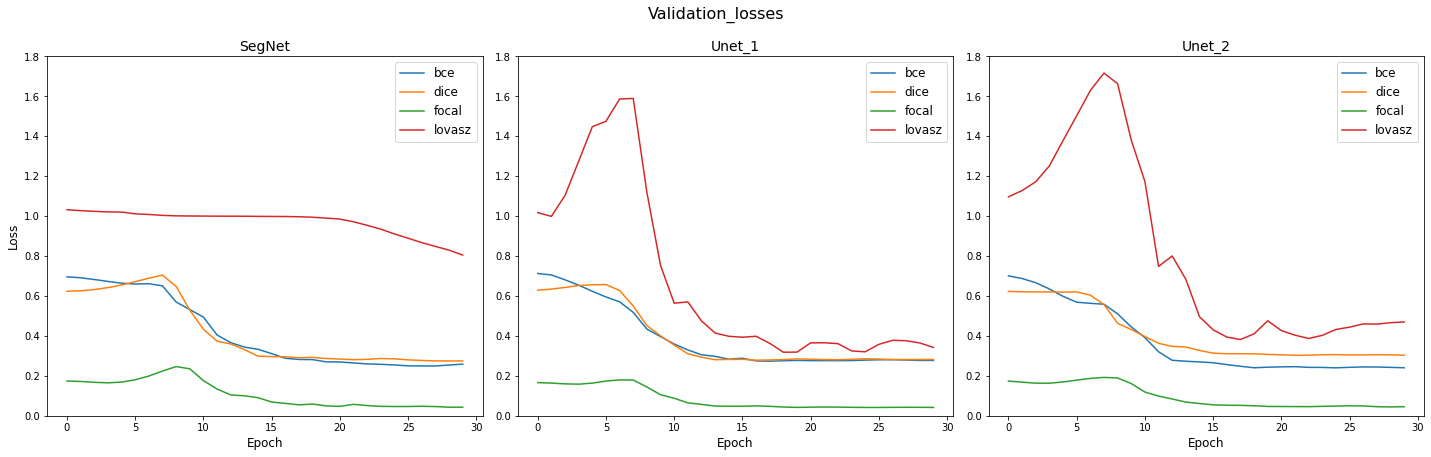

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
for i, loss_name in enumerate(['bce','dice','focal','lovasz']):
    ax[0].plot(segnet_histories[i]['val_losses'], label=loss_name)
    ax[0].legend(fontsize=12)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].set_ylim(0,1.8)
    ax[1].plot(unet1_histories[i]['val_losses'], label=loss_name)
    ax[1].legend(fontsize=12)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylim(0,1.8)
    ax[2].plot(unet2_histories[i]['val_losses'], label=loss_name)
    ax[2].legend(fontsize=12)
    ax[2].set_xlabel('Epoch', fontsize=12)
    ax[2].set_ylim(0,1.8)
ax[0].set_title('SegNet', fontsize=14)
ax[1].set_title('Unet_1', fontsize=14)
ax[2].set_title('Unet_2', fontsize=14)
plt.suptitle('Validation_losses', fontsize=16, y=1.05)
plt.tight_layout();



Из вышепостроенных графиков можно уже сделать кое-какие выводы:

1) Самая численно-стабильная функция потерь - это focal loss, её противоположность в этом плане - lovasz loss


2) Во всех случаях были моменты, когда из-за седловых точек градиентный спуск тормозил


3) Градация лоссов по мере обучения у моделей Unet1 и Unet2 очень похожа, но bce лосс по абсолютному значению к концу обучения выше у модели Unet1, то есть можно сделать предположение, что с bce обучается лучше модель Unet2 (но естественно на 100 процентов утверждать это мы не можем)

In [ ]:
segnet_val_scores

{'bce': 0.8238397538661957,
 'dice': 0.8369950950145721,
 'focal': 0.826583743095398,
 'lovasz': 0.7468820512294769}

In [ ]:
unet1_val_scores

{'bce': 0.8446248471736908,
 'dice': 0.8452585339546204,
 'focal': 0.8502940237522125,
 'lovasz': 0.8474801182746887}

In [ ]:
unet2_val_scores

{'bce': 0.8553267121315002,
 'dice': 0.8359119892120361,
 'focal': 0.8369656503200531,
 'lovasz': 0.8155865967273712}

Оценим теперь как менялись значения метрики на валидационных данных для каждой из 3 моделей:

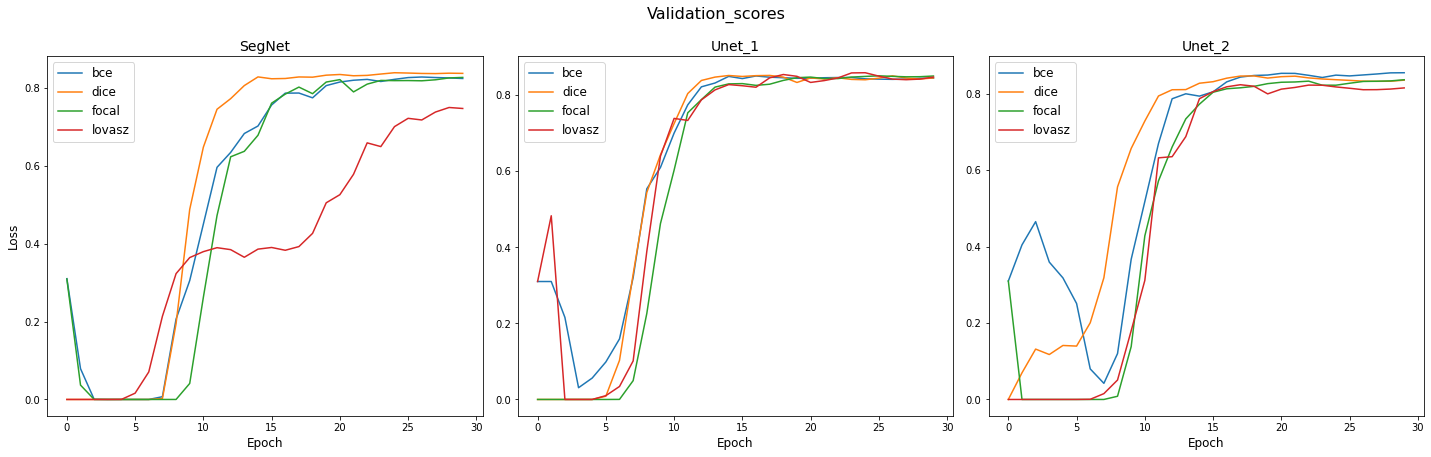

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
for i, loss_name in enumerate(['bce','dice','focal','lovasz']):
    ax[0].plot(segnet_histories[i]['val_scores'], label=loss_name)
    ax[0].legend(fontsize=12)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[1].plot(unet1_histories[i]['val_scores'], label=loss_name)
    ax[1].legend(fontsize=12)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[2].plot(unet2_histories[i]['val_scores'], label=loss_name)
    ax[2].legend(fontsize=12)
    ax[2].set_xlabel('Epoch', fontsize=12)
ax[0].set_title('SegNet', fontsize=14)
ax[1].set_title('Unet_1', fontsize=14)
ax[2].set_title('Unet_2', fontsize=14)
plt.suptitle('Validation_scores', fontsize=16, y=1.05)
plt.tight_layout();

Из графиков выше уже можно сделать более определённые выводы:

1) Можно утверждать, что из всех 3 моделей со всеми функциями потерь наилучший результат показывает Unet1 (исключая bce), skip-connections работают отлично и позволяют обобщить разноуровневую информацию и, таким образом, улучшают качество сегментации.  

2) SegNet проявил себя хуже всех моделей, что в принципе вполне логично, ибо в её архитектуре всё более менее стандартно и знакомо.

3) Unet2 работает почти на уровне Unet1 по своему качеству сегментации (что в принципе неудивительно - skip-connections есть и в той, и в другой архитектуре)

4) Самые эффективные функции потерь для решения сегментации похоже - это бинарная кросс-энтропия, dice loss и lovasz loss (однако на SegNet lovasz loss "провалился" на фоне остальных, но это скорее всего из-за специфики этого вида функции потерь - она требует более изощрённую архитектуру)

5) Теперь лично моё мнение насчёт лучшей комбинации model + loss и самой оптимальной функции потерь для решения нашей задачи сегментации. Я думаю, что лучшая суперсвязка - это Unet1 + dice loss (даже несмотря на лучший результат у пары Unet2 + bce). Самая оптимальная функция в плане решения задачи - опять таки вышеобозначенная, ибо она одинаково хорошо проявила себя на всех 3 нейросетях. А почётное второе место отдаю lovasz loss и bce (сложно отдать предпочтение чему-то одному)

Наконец, оценим среднее качество предсказаний наших моделей на тестовых данных - для каждой модели (для различных функций потерь) и в рамках всевозможных комбинаций вообще. 

Для каждой модели будет удобно построить гистограмму значений (предварительно напишем функцию для сортировки словаря):

In [ ]:
def sort_dict (dictionary):
  sorted_turple = sorted(dictionary.items(),  key= lambda x: x[1])
  sorted_dict = dict(sorted_turple)
  return sorted_dict

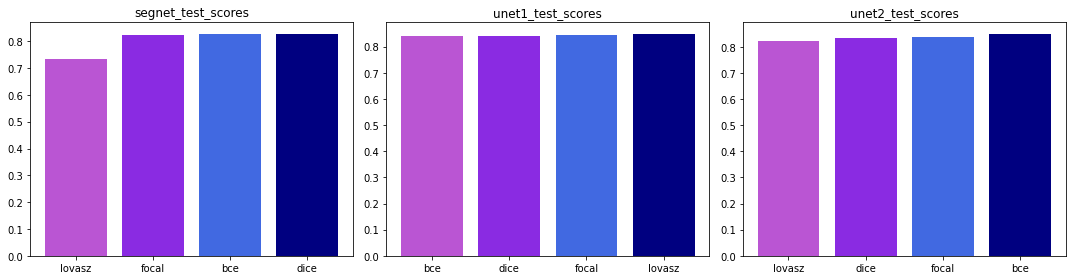

In [ ]:
fig, axs = plt.subplots(1, 3)

axs[0].bar(sort_dict(segnet_test_scores).keys(), sort_dict(segnet_test_scores).values(), color = ['mediumorchid', 'blueviolet', 'royalblue', 'navy'])
axs[0].set_title('segnet_test_scores')
axs[1].bar(sort_dict(unet1_test_scores).keys(), sort_dict(unet1_test_scores).values(), color = ['mediumorchid', 'blueviolet', 'royalblue', 'navy'])
axs[1].set_title('unet1_test_scores')
axs[2].bar(sort_dict(unet2_test_scores).keys(), sort_dict(unet2_test_scores).values(), color=['mediumorchid', 'blueviolet', 'royalblue', 'navy'])
axs[2].set_title('unet2_test_scores')
plt.tight_layout()

Итак, на тестовых данных картинка в принципе не так уж сильно поменялась - на SegNet произошла рокировка bce и focal по сравнению с данными на валидации, на Unet1 поменялись местами focal и lovasz, но это скорее всего связано уже со спецификой самих медицинских снимков

Теперь вычленим различные скоры для определённого вида функции потерь для каждой модели и построим гистограмму значений - для того, чтобы понять какие модели проявили себя лучше остальных. 

In [ ]:
bce_test_scores = {'SegNet': segnet_test_scores['bce'], 'Unet_1' : unet1_test_scores['bce'], 'Unet_2': unet2_test_scores['bce']}
dice_test_scores = {'SegNet': segnet_test_scores['dice'], 'Unet_1': unet1_test_scores['dice'], 'Unet_2': unet2_test_scores['dice']}
focal_test_scores = {'SegNet': segnet_test_scores['focal'], 'Unet_1': unet1_test_scores['focal'], 'Unet_2': unet2_test_scores['focal']}
lovasz_test_scores = {'SegNet': segnet_test_scores['lovasz'], 'Unet_1': unet1_test_scores['lovasz'], 'Unet_2': unet2_test_scores['lovasz']}


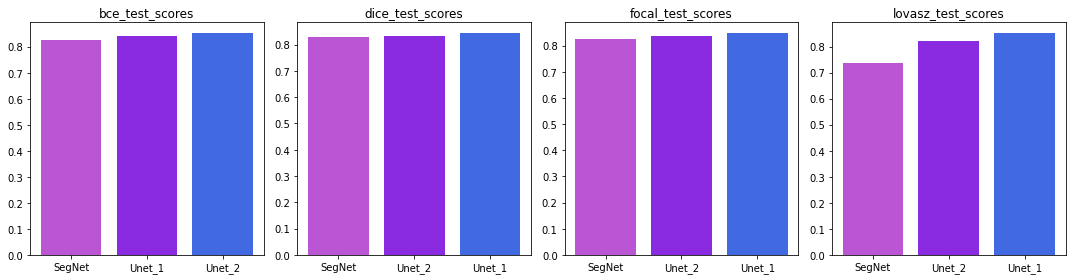

In [ ]:
fig, axs = plt.subplots(1, 4)

axs[0].bar(sort_dict(bce_test_scores).keys(), sort_dict(bce_test_scores).values(), color=['mediumorchid', 'blueviolet', 'royalblue'])
axs[0].set_title('bce_test_scores')
axs[1].bar(sort_dict(dice_test_scores).keys(), sort_dict(dice_test_scores).values(), color=['mediumorchid', 'blueviolet', 'royalblue'])
axs[1].set_title('dice_test_scores')
axs[2].bar(sort_dict(focal_test_scores).keys(), sort_dict(focal_test_scores).values(), color=['mediumorchid', 'blueviolet', 'royalblue'])
axs[2].set_title('focal_test_scores')
axs[3].bar(sort_dict(lovasz_test_scores).keys(), sort_dict(lovasz_test_scores).values(), color=['mediumorchid', 'blueviolet', 'royalblue'])
axs[3].set_title('lovasz_test_scores')
plt.tight_layout()

Как и предполагалось, доминирует почти везде Unet1 - она и будет лучшей моделью для решения нашей задачи. Unet2 немного отстаёт, но вкупе с бинарной кросс-энтропией даже опережает Unet1. SegNet на почётном 3 месте. 

В целом, самый главный урок, который можно извлечь для себя из этого домашнего задания - усложнения архитектуры моделей (конечно же продуманные) приводят к наилучшим результатам, так как в сегментации родинок - мелоном необходимо научить сеть чётко, а главное правильно выделять как ровные образования, так и с необычными и извилистыми границами. Из этого вытекает и то, что необходимо усложнять функции потерь (конечно оправданным образом, чтобы подточить её под решение определённой задачи - в нашем случае сегментации снимков).

